In [129]:
import pickle
import re
from math import sqrt
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.core.display import HTML, display

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.gridspec as GS
from seaborn import PairGrid, heatmap, kdeplot, FacetGrid, scatterplot, cubehelix_palette
import cmocean.cm as cmo
import arviz as az

import pymc3 as pm
from pymc_utils import subset_significant_feature

In [26]:
def create_smry(trc, labels, vname=['w'], alpha=0.05,
                sort=False, abs_sort=False, **kwargs):
    ''' Conv fn: create trace summary for sorted forestplot '''
    hpd_lo, hpd_hi = 100 * (alpha / 2), 100 * (1 - alpha / 2)
    subset_ = kwargs.pop('subset_significant', False)
    dfsm = pm.summary(trc, varnames=vname, alpha=alpha)
    dfsm.rename(index={wi: lbl for wi, lbl in zip(dfsm.index, labels)},
                inplace=True)
    if subset_:
        dfsm = dfsm[(((dfsm[f'hpd_{hpd_lo}']<0)&(dfsm[f'hpd_{hpd_hi}']<0))|
                    ((dfsm[f'hpd_{hpd_lo}']>0) & (dfsm[f'hpd_{hpd_hi}']>0))
                   )]
    if sort:
        dfsm.sort_values('mean', ascending=True, inplace=True)
    elif abs_sort:
        dfsm['abs_mean'] = np.abs(dfsm['mean'])
        dfsm.sort_values('abs_mean', ascending=False, inplace=True)
    dfsm['ypos'] = np.linspace(1, 0, len(dfsm))
    return dfsm


def custom_forestplot(df, ax, replace_bathy=True):
    ax.scatter(x=df['mean'], y=df.ypos, edgecolor='k', facecolor='white', zorder=2)
    ax.hlines(df.ypos, xmax=df['hpd_97.5'], xmin=df['hpd_2.5'],
              color='k', zorder=1, linewidth=3)
    ax.set_yticks(df.ypos)
    ax.set_yticklabels(df.index.tolist())
    ax.axvline(linestyle=':', color='k')
    ax.grid(axis='y', zorder=0)

    
def plot_pairwise_map(df, ax=None, annot=False):
    if ax is None:
        _, ax = pl.subplots(figsize=(20, 20))
    dfc = df.corr().iloc[1:, :-1]
    heatmap(dfc, vmin=-1, vmax=1, cmap=cmo.balance_r, annot=annot, annot_kws={'fontsize': 6},
            ax=ax, mask=np.triu(np.ones([dfc.shape[1]]*2), k=1), fmt='.1f',
           linewidths=0.5, linecolor='black')
    ax.set_facecolor('k')
    return ax


def plot_obs_against_ppc(y_obs, ppc, ax=None, plot_1_to_1=False,
                         add_label=True, **scatter_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 10))
    ppc_mean = ppc.mean(axis=0)
    mae = mean_absolute_error(y_obs, ppc_mean)
    r2 = r2_score(y_obs, ppc_mean)
    if add_label:
        scatter_lbl = scatter_kwds.pop('label', '')
        scatter_lbl = fr'{scatter_lbl}; {r2:.2f}; {mae:.2f}'
        ax.scatter(y_obs, ppc_mean, edgecolor='k', label=scatter_lbl, **scatter_kwds)
    else:
        ax.scatter(y_obs, ppc_mean, edgecolor='k', **scatter_kwds)
    if plot_1_to_1:
        min_ = min(ppc_mean.min(), y_obs.min())
        max_ = max(ppc_mean.max(), y_obs.max())
        ax.plot([min_, max_], [min_, max_], ls='--', color='k', label='1:1')
    ax.legend(loc='upper left')
    return ax


def plot_fits_w_estimates(y_obs, ppc, ax=None, legend=False):
    """ Plot Fits with Uncertainty Estimates"""
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean = ppc.mean(axis=0)
    lik_hpd = pm.hpd(ppc)
    lik_hpd_05 = pm.hpd(ppc, alpha=0.5)
    r2 = r2_score(y_obs, lik_mean)
    mae = mean_absolute_error(y_obs, lik_mean)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
    ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=40,
               color='w', marker='d', zorder=2);
    ax.scatter(ix, lik_mean[iy], label='model mean -- $r^2$=%.2f -- mae=%.2f' %(r2, mae),
               edgecolor='k', s=40, color='w', zorder=3)

    ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], color='gray', 
                   label='model output 50%CI', zorder=1,linestyle='-', lw=2, edgecolor='k');
    ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], color='k', alpha=0.75,
                   label='model output 95%CI', zorder=0, );
    if legend:
        ax.legend(loc='upper left');
    return ax


def compute_fig_height(fig_width):
    golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
    return fig_width*golden_mean # height in inches


def latexify(fig_width=None, fig_height=None, columns=1, square=False):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    PNAS 1-column figure width should be 3.5"
    PNAS 2-column wide figures should be 4.49" or 7" (??)
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf
    
    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.43 if columns==1 else 4.49 # width in inches

    if fig_height is None:
        if square:
            fig_height = fig_width
        else:
            fig_height =  compute_fig_height(fig_width) # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    rcParams.update(params)

#### Load linear regression results:

In [5]:
"""hshoe_mdl_dict[m_hshoe_510.model.name] = dict(model=m_hshoe_510.model,
                                              trace=m_hshoe_510.trace_,
                                              ppc_train=ppc_train_510,
                                              ppc_test=ppc_test_510)
"""
with open('./pickleJar/HSHOE_MDL_DICT.pkl', 'rb') as fb:
    hshoe_mdl_dict = pickle.load(fb)

#### Load linear regression with interactions results:

In [6]:
with open('./pickleJar/Results_190118/hshoe_wi_model_dict.pkl', 'rb') as fb:
    hshoe_mdl_w_int_dict = pickle.load(fb)

#### Load bayesian neural network results:

In [165]:
with open('./pickleJar/Results_190118/bnn_model_dict.pkl', 'rb') as fb:
    bnn_mdl_dict = pickle.load(fb)

In [166]:
bnn_mdl_dict.keys()

dict_keys([411, 443, 489, 510, 555, 670])

In [9]:
with open('./pickleJar/AphiTrainTestSplitDataSets.pkl', 'rb') as fb:
    datadict = pickle.load(fb)
X_s_train = datadict['x_train_s']
y_train = datadict['y_train']
X_s_test = datadict['x_test_s']
y_test = datadict['y_test']
X_s_train_w_int = datadict['x_train_wi_s']
X_s_test_w_int = datadict['x_test_wi_s']

In [10]:
X_s_train.head()

,dep,sst,solz,pc1,pc2,pc3,pc4,pc5,pc6
104,1.561812,0.980019,-0.652818,0.189974,-0.414644,-0.933887,-0.510384,0.285450,0.064361
98,1.667105,-0.455988,-0.472027,0.579478,-0.554825,-0.349339,-0.066203,-1.129648,0.660823
16,-0.768789,-0.912078,0.498893,-0.484867,0.421179,-0.301039,0.747057,-0.227188,-0.363760
75,-0.742689,1.387941,-0.873786,0.084072,-0.869452,-0.196910,1.052647,0.434195,-0.296654
18,-1.067195,0.055796,1.208669,-1.146327,2.335666,-1.018783,-0.174597,1.969049,-1.271384


In [11]:
X_s_train_w_int.head()

,dep,sst,solz,pc1,pc2,pc3,pc4,pc5,pc6,dep sst,...,pc2 pc3,pc2 pc4,pc2 pc5,pc2 pc6,pc3 pc4,pc3 pc5,pc3 pc6,pc4 pc5,pc4 pc6,pc5 pc6
104,1.561812,0.980019,-0.652818,0.189974,-0.414644,-0.933887,-0.510384,0.285450,0.064361,1.530605,...,0.387230,0.211627,-0.118360,-0.026687,0.476641,-0.266578,-0.060106,-0.145689,-0.032849,0.018372
98,1.667105,-0.455988,-0.472027,0.579478,-0.554825,-0.349339,-0.066203,-1.129648,0.660823,-0.760180,...,0.193822,0.036731,0.626757,-0.366641,0.023127,0.394630,-0.230851,0.074786,-0.043748,-0.746497
16,-0.768789,-0.912078,0.498893,-0.484867,0.421179,-0.301039,0.747057,-0.227188,-0.363760,0.701195,...,-0.126791,0.314645,-0.095687,-0.153208,-0.224893,0.068392,0.109506,-0.169722,-0.271749,0.082642
75,-0.742689,1.387941,-0.873786,0.084072,-0.869452,-0.196910,1.052647,0.434195,-0.296654,-1.030809,...,0.171204,-0.915226,-0.377512,0.257926,-0.207277,-0.085497,0.058414,0.457055,-0.312272,-0.128806
18,-1.067195,0.055796,1.208669,-1.146327,2.335666,-1.018783,-0.174597,1.969049,-1.271384,-0.059546,...,-2.379536,-0.407800,4.599041,-2.969529,0.177876,-2.006033,1.295264,-0.343789,0.221979,-2.503417


In [12]:
feature_labels = X_s_train.columns.tolist()
feature_w_int_labels = X_s_train_w_int.columns.tolist() 

In [13]:
bnn_411_feature_labels = [r'%s$\rightarrow$%d' %(feature, unit)
                         for feature in feature_labels for unit in range(1, 5)]

HEATMAP

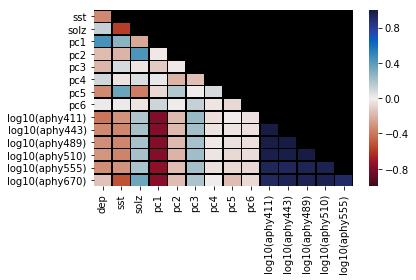

In [15]:
#latexify(fig_height=3.4)
f, ax = pl.subplots()
ax = plot_pairwise_map(pd.concat((X_s_train, y_train), axis=1), ax=ax,)
f.tight_layout()
f.savefig('./figJar/aphy_heatmap.pdf')

FORESTPLOTS

In [136]:
dfs_reg_411 = create_smry(hshoe_mdl_dict['hshoe_aphy411']['trace'], feature_labels, abs_sort=True,
                         subset_significant=True)
dfs_reg_wi_411 = create_smry(hshoe_mdl_w_int_dict[411]['trace'], feature_w_int_labels,
                             abs_sort=True, subset_significant=True)
dfs_bnn_411 = create_smry(bnn_mdl_dict[411]['trace'],
                          bnn_411_feature_labels, vname=['wts_i_1'], abs_sort=True,
                         subset_significant=True)

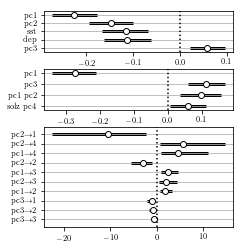

In [137]:
latexify(fig_height=3.5)
f_forest = pl.figure(constrained_layout=True)
gs = f_forest.add_gridspec(4, 1)
ax1 = f_forest.add_subplot(gs[0])
ax2 = f_forest.add_subplot(gs[1])
ax3 = f_forest.add_subplot(gs[2:])
custom_forestplot(dfs_reg_411, ax=ax1)
custom_forestplot(dfs_reg_wi_411, ax=ax2)
custom_forestplot(dfs_bnn_411, ax=ax3)
f_forest.tight_layout()
f_forest.subplots_adjust(hspace=0.4)

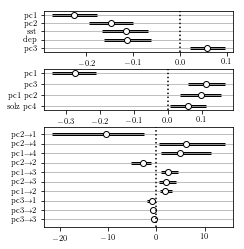

In [71]:
latexify(fig_height=3.5)
f_forest = pl.figure(constrained_layout=True)
gs = f_forest.add_gridspec(4, 1)
ax1 = f_forest.add_subplot(gs[0])
ax2 = f_forest.add_subplot(gs[1])
ax3 = f_forest.add_subplot(gs[2:])
custom_forestplot(dfs_reg_411, ax=ax1)
custom_forestplot(dfs_reg_wi_411, ax=ax2)
custom_forestplot(dfs_bnn_411, ax=ax3)
f_forest.tight_layout()
f_forest.subplots_adjust(hspace=0.4)
f_forest.savefig('./figJar/forest_411.pdf')


SCATTERPLOTS

In [73]:
hshoe_mdl_dict.keys()

dict_keys(['hshoe_aphy411', 'hshoe_aphy443', 'hshoe_aphy489', 'hshoe_aphy510', 'hshoe_aphy555', 'hshoe_aphy670'])

In [167]:
bands = [411, 443, 489, 510, 555, 670]
ppc_test_hs_dict = {l: hshoe_mdl_dict['hshoe_aphy%d' %l]['ppc_test'] for l in bands}
ppc_test_hs_wi_dict = {l: hshoe_mdl_w_int_dict[l]['ppc_test'] for l in bands}
ppc_test_bnn_dict = {l: bnn_mdl_dict[l]['ppc_test'] for l in bands}

In [130]:
def make_scatter_plot(ppc_test_dict, cm_name='gist_yarg'):
    cmap = cm.get_cmap('gist_yarg')
    normalize = Normalize(vmin=min(bands), vmax=max(bands))
    colors = [cmap(normalize(value)) for value in bands]
    latexify(square=True)
    f, ax_ = pl.subplots()
    for i, band in enumerate(bands):
        plot_obs_against_ppc(y_test['log10_aphy%d' %band], ppc_test_dict[band],
                             s=40, ax=ax_, c=colors[i], label='%d' % band)
    ax_.plot([-3.4, -1], [-3.4, -1], color='k', ls='--')
    ax_.legend(title=r'a$\phi$ band; r$^2$; mae', fontsize=7, loc='upper left',
       frameon=False, markerscale=0.7, markerfirst=True)
    ax_.set_xlabel('model output mean')
    ax_.set_ylabel('observed')
    f.tight_layout()
    return f


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

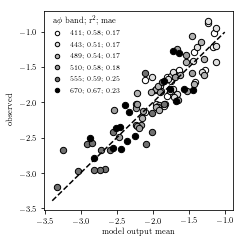

In [131]:
f_sc_reg = make_scatter_plot(ppc_test_hs_dict)

In [132]:
f_sc_reg.savefig('./figJar/scatter_lin_reg.pdf', format='pdf', dpi=300)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

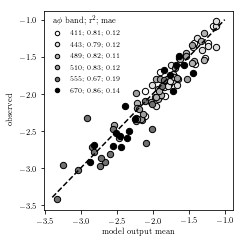

In [133]:
f_sc_reg_wi = make_scatter_plot(ppc_test_hs_wi_dict)
f_sc_reg_wi.savefig('./figJar/scatter_lin_reg_wi.pdf', format='pdf', dpi=300)

## PPCPLOTS

In [ ]:
f_sc_bnn = make_scatter_plot(ppc_test_bnn_dict)
f_sc_bnn.savefig('./figJar/scatter_lin_reg_wi.pdf', format='pdf', dpi=300)

In [87]:
ppc_test_bnn_dict[411].shape, ppc_test_hs_dict[411].shape, ppc_test_hs_wi_dict[411].shape

((8000, 145), (8000, 17), (8000, 17))

In [115]:
ppc_test_bnn_dict[411] = ppc_a

In [157]:

ai = [i for i in axi.get_yticklabels()]

In [159]:
a0 = ai[0]

In [164]:
10**float(a0.get_text().strip('$'))

0.001

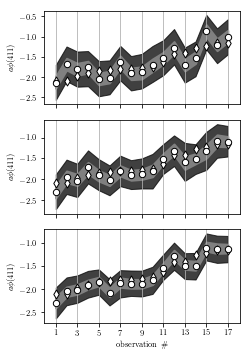

In [152]:
latexify(fig_height=5, )
f, ax = pl.subplots(nrows=3, sharex=True)
for axi, ppc_test_dict in zip(ax, [ppc_test_hs_dict, ppc_test_hs_wi_dict, ppc_test_bnn_dict]):
    plot_fits_w_estimates(y_obs=y_test['log10_aphy411'],
                              ppc=ppc_test_dict[411], ax=axi)
    axi.grid(axis='x', which='both')
    axi.set_ylabel(r'$a\phi(411)$')
axi.set_xlabel(r'observation \#');
axi.set_xticks(np.arange(0,17, 2))
axi.set_xticklabels(np.arange(1, 18, 2))
f.tight_layout()
f.savefig('./figJar/aphi_test_sets_HDI.pdf')

### MODEL PLATE

In [172]:
with open('./pickleJar/Hshoe_example_model.pkl', 'rb') as fb:
    mhsoe_mdl = pickle.load(fb)

In [111]:
from theano import shared
y_shared = shared(y_test.log10_aphy411.values)

In [112]:
ppc = pm.sample_posterior_predictive(trace=bnn_mdl_dict[411]['trace'], model=bnn_mdl_dict[411]['model'],
                              vars=[y_shared])

100%|██████████| 8000/8000 [00:00<00:00, 13772.85it/s]


(17, 9)

In [113]:
ppc_a = ppc[None]

In [114]:
ppc_a.shape

(8000, 17)

In [117]:
mdl = bnn_mdl_dict[411]['model']

In [123]:
mdl.vars

[hyp_w_i_1_sd_log__,
 hyp_w_1_out_sd_log__,
 hyp_bias_1_sd_log__,
 wts_i_1_intrmd_ordered__,
 wts_1_o_intrmd,
 bias_1_ordered__,
 bias_o,
 sd_log__]

In [124]:
with open('./pickleJar/BNN181210/HlfCchyHypPriors/models.pkl', 'rb') as fb:
    m = pickle.load(fb)

In [125]:
m.keys()

dict_keys(['bnn_L1_4HL_411', 'bnn_L1_4HL_443', 'bnn_L1_4HL_489', 'bnn_L1_4HL_510', 'bnn_L1_4HL_555', 'bnn_L1_4HL_670'])

In [127]:
mdl = m['bnn_L1_4HL_411']

In [ ]:
mdl.predict()